# Noise
*BeamNG.tech only*

This example shows how to get non-perfect measurements/apply noise to the images. 
The sensor library has also been restructured to an approach, where the sensor class has its own `data` property.
Before, the sensor data was a return value of the `Vehicle.poll_sensors` class.

## Setup

The `RandomImageNoise` class is a wrapper class for the `skimage.utils.noise.random_noise` function. 
Since the installation for this package is not required to use BeamNGpy, it has to be installed manually ro use the noise module.
See scikit-image.org for install instructions and a documentation of the possible values.


In [35]:
import matplotlib.pyplot as plt
import numpy as np
from beamngpy import BeamNGpy, Scenario, Vehicle
from beamngpy.sensors import noise
from beamngpy.sensors import Camera
from time import sleep

## Setting up Scenario

In [36]:
beamng = BeamNGpy('localhost', 64256)
beamng.open()
scenario = Scenario('west_coast_usa', 'noise demo')
vehicle = Vehicle('test_car', model='etk800')

scenario.add_vehicle(vehicle, pos=(-717.121, 101, 118.675), rot_quat=(0, 0, 0.3826834, 0.9238795))
scenario.make(beamng)

beamng.load_scenario(scenario)
beamng.step(60)

## Setting Up Noise

The Noise class is designed in such a way,
that different instances of noise can be combined on top of each other.
With `RandomImageNoise` it is possibe to apply noise to depth and/or rgb images of the `Camera` class.

In this example we will use three types of noise sensors:

1. gaussian, which is the default type of noise used, if no other parameters are specified

2. salt and pepper, with more salt then pepper, which is also applied to the depth and colour image

3. a camera sensor, where gaussian noise is applied to depth image and poisson noise is applied to the colour image.

For the selection of parameters it is important to note, that the noise is applied to an image whose values are in \[0, 1\].

In [37]:
pos = (-0.3, 1, 1.0)
direction = (0, 1, 0)
fov = 120
resolution = (512, 512)
print(vehicle)
gauss_cam = Camera('gauss', beamng, vehicle, pos=pos, dir=direction, field_of_view_y=fov, resolution=resolution) 
snp_cam = Camera('snp', beamng, vehicle, pos=pos, dir=direction, field_of_view_y=fov, resolution=resolution) 
multi_noise_cam = Camera('multinoise', beamng, vehicle, pos=pos, dir=direction, field_of_view_y=fov, resolution=resolution) 

gauss = noise.RandomImageNoise(gauss_cam)
snp = noise.RandomImageNoise(snp_cam, mode="s&p", amount=0.5, salt_vs_pepper=0.8)
multi_noise = noise.RandomImageNoise(multi_noise_cam, colour=False, depth=True, mode="gaussian", mean=0, var=0.2)
multi_noise = noise.RandomImageNoise(multi_noise, colour=True, depth=False, mode="poisson")

V:test_car


## Running Simulation and Acquiring Data 

In [38]:
sleep(3)

gauss_data = gauss_cam.poll()
snp_data = snp_cam.poll()
multi_data = multi_noise_cam.poll()

beamng.close()

## Noise Visualization

### Gauss 

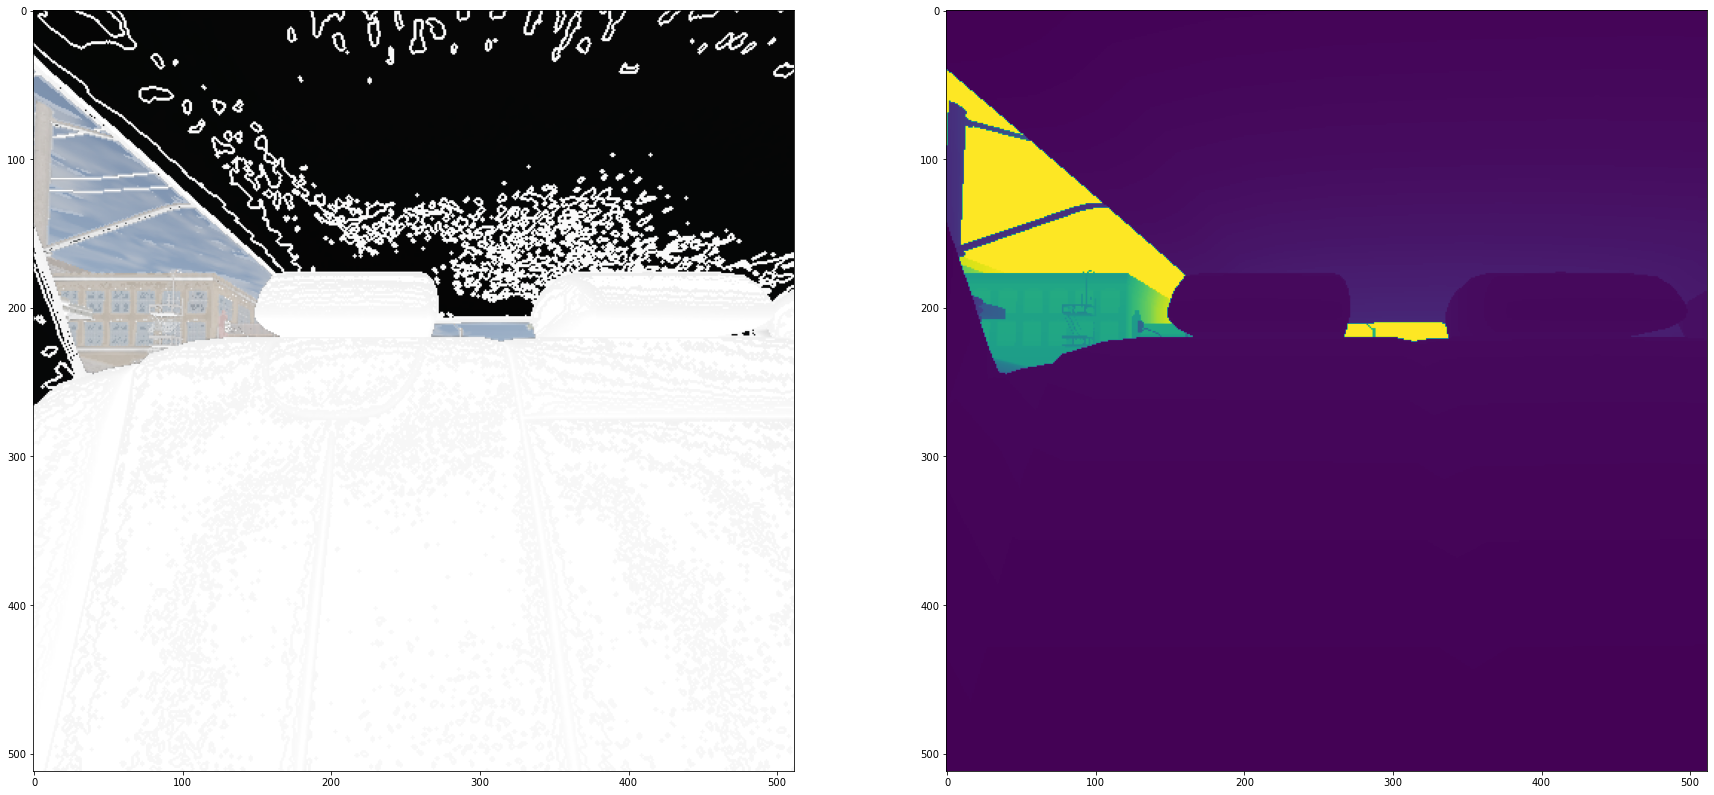

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(30, 30))
ax[0].imshow(np.array(gauss_data['colour']))
ax[1].imshow(np.array(gauss_data['depth']))

### Salt and Pepper

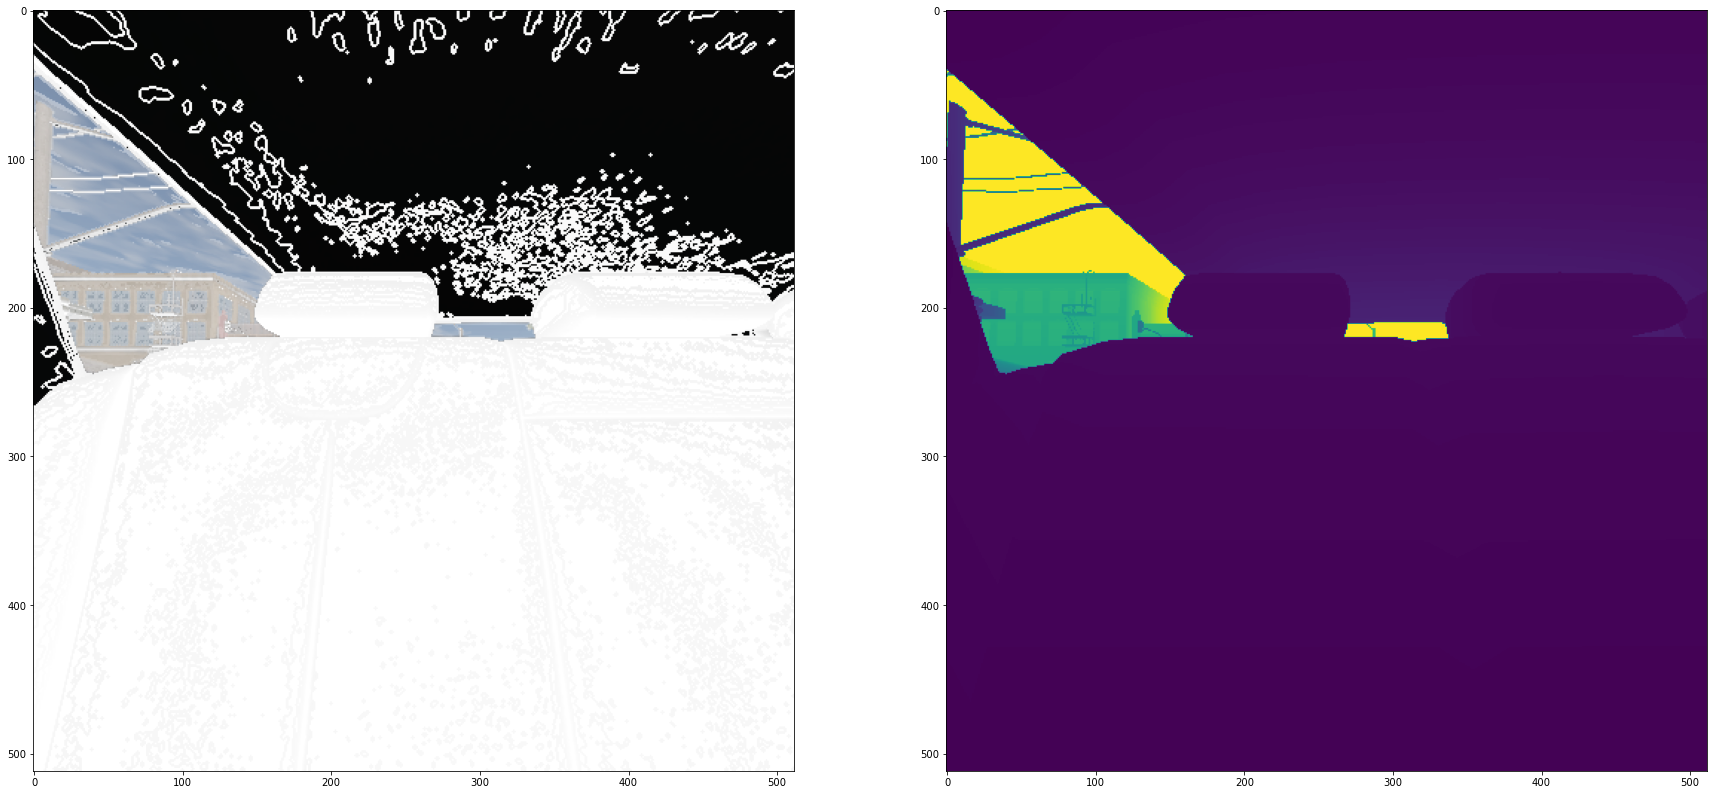

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(30, 30))
ax[0].imshow(np.array(snp_data['colour']))
ax[1].imshow(np.array(snp_data['depth']))

### Poisson and Gauss

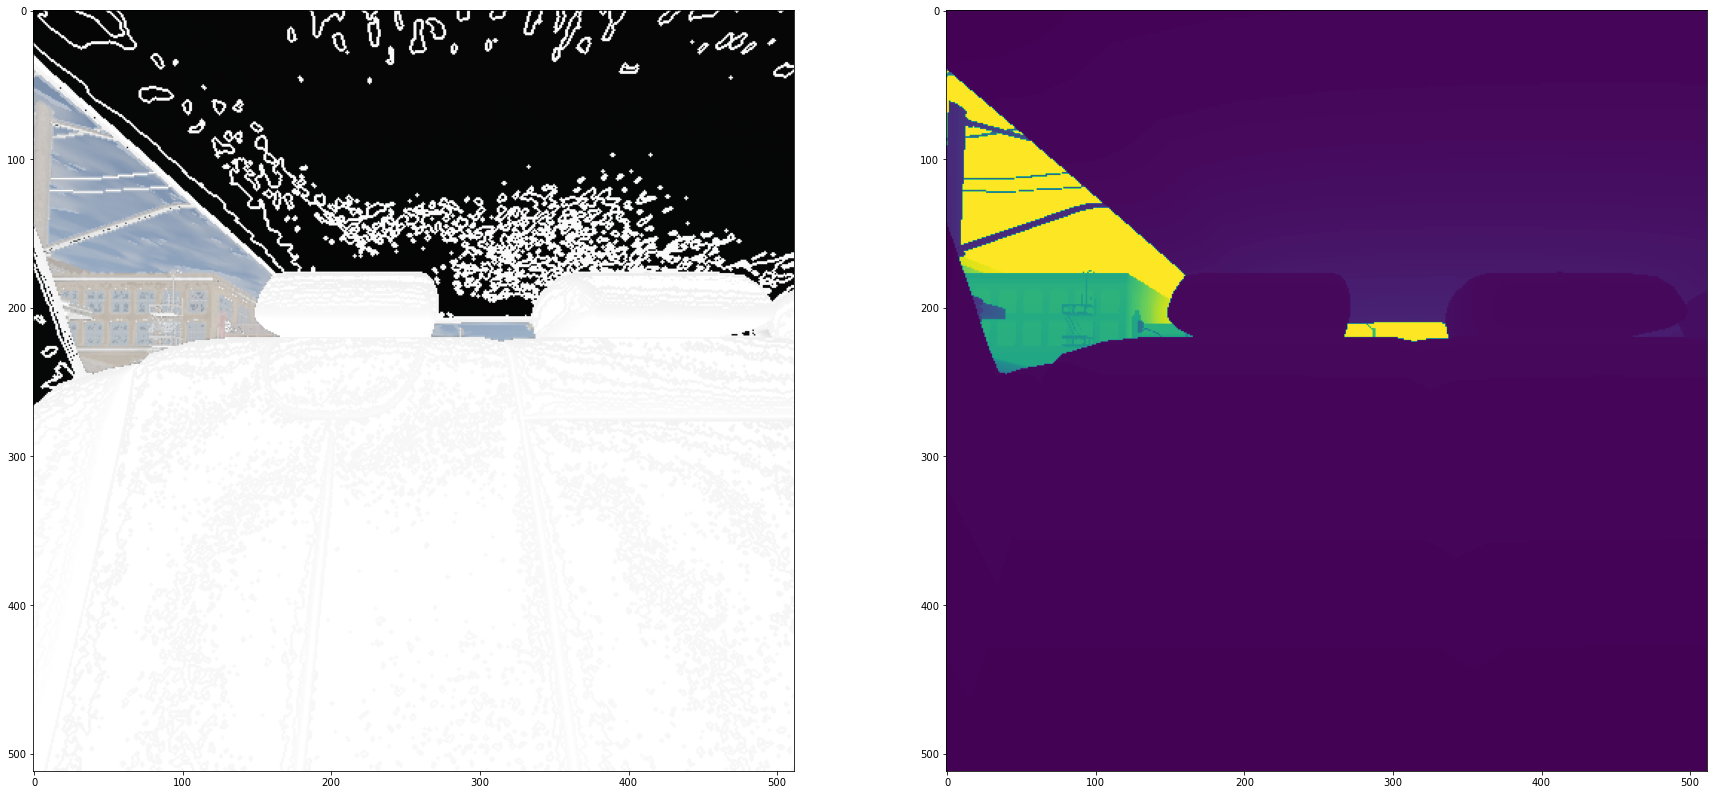

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(30, 30))
ax[0].imshow(np.array(multi_data['colour']))
ax[1].imshow(np.array(multi_data['depth']))

### Original
The original data can always be accessed through the data property of the camera sensor.

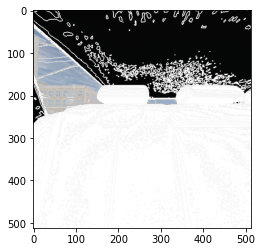

In [42]:
plt.imshow(np.array(gauss_data['colour']))
